In [22]:
!nvidia-smi

Wed May 31 05:45:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:04:00.0 Off |                    0 |
|  0%   43C    P0    77W / 300W |  44815MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A40          Off  | 00000000:83:00.0 Off |                    0 |
|  0%   

In [2]:
# ignore this cell -- stuff for our server
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HTTP_PROXY']='http://proxy:3128/'
os.environ['HTTPS_PROXY']='http://proxy:3128/'

In [3]:
# imports
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimage

tfkl = tf.keras.layers

from collections import Counter

2023-05-29 09:39:26.056545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 09:39:27.732962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/johannsm/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-05-29 09:39:27.733080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

In [4]:
# this uses the wiki text data set.
# can be downloaded here https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/
# I use the word level version

def process_data(path, keep_num_tokens):
    print("Reading training data...")
    with open(os.path.join(path, "wiki.train.tokens"), "r") as train_file:
        train_full = train_file.read()
    train_full = train_full.split(" ")
        
    print("Reading validation data...")
    with open(os.path.join(path, "wiki.valid.tokens"), "r") as valid_file:
        valid_full = valid_file.read()
    valid_full = valid_full.split(" ")
    
    
    print("Counting tokens...")
    vocab_counter = Counter(train_full)
    vocab_count = vocab_counter.most_common()

    plt.loglog([v[1] for v in vocab_count])
    plt.xlabel("Token index (sorted)")
    plt.ylabel("Number of occurrences")
    plt.show()
    
    cutoff = keep_num_tokens
    common_tokens = set([pair[0] for pair in vocab_count[:cutoff]])

    vocabulary = common_tokens
    print(vocabulary)
    
    ind_to_token = dict(zip(range(len(vocabulary)), vocabulary))
    #ind_to_token[cutoff] = "<UNK>"
    token_to_ind = {t: i for (i, t) in ind_to_token.items()}
    unk_ind = token_to_ind["<unk>"]
    
    print("Tokenizing train...")
    train_tokenized = [token_to_ind.get(token, unk_ind) for token in train_full]
    print("Tokenizing valid...")
    valid_tokenized = [token_to_ind.get(token, unk_ind) for token in valid_full]
    
    return train_tokenized, valid_tokenized, ind_to_token, token_to_ind, len(vocabulary)

Reading training data...
Reading validation data...
Counting tokens...


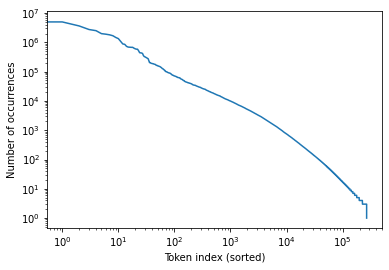

{'528', 'tenets', 'calm', 'British', 'Maui', 'amber', 'cape', 'Strike', 'Belly', 'Sovereign', 'audiobook', 'Vieira', 'Farnborough', 'income', 'Yolanda', 'evolved', 'overflowed', 'Sixty', 'ECB', 'examples', 'Sentinel', 'Scherzinger', 'dyeing', 'desperate', 'solitary', 'Pavilions', 'puns', 'pianist', 'harmonies', 'keyboard', 'renovations', 'mobilized', 'trafficked', 'Disasters', 'Attractions', 'dubbed', 'Gibbon', 'Moroccan', '348', 'Commando', 'lottery', 'metaphorically', 'mis', '15s', 'astride', '243', 'alarmed', 'Roanoke', 'Bluffs', 'sulphur', 'Drain', 'AKC', 'squads', 'cutscene', 'mixtape', 'cult', 'ecosystems', 'Kikuta', 'Biographical', 'thief', '461', 'identity', 'Pride', 'rings', 'Anfield', 'Surabaya', 'bicycles', 'watering', 'relented', 'Amos', 'Medici', 'postures', 'CAF', 'nemesis', 'Consequently', 'wander', 'Kirchherr', 'obverse', 'Cabildo', 'Lautner', 'Kesteven', 'Lympne', 'apparition', 'workout', 'attacking', 'penchant', 'captivated', 'recovers', 'Covarrubias', 'canton', 'Glad

Tokenizing valid...


In [5]:
path = "data/wikitext-103"
train_tokenized, valid_tokenized, ind_to_token, token_to_ind, num_tokens = process_data(path, 50000)

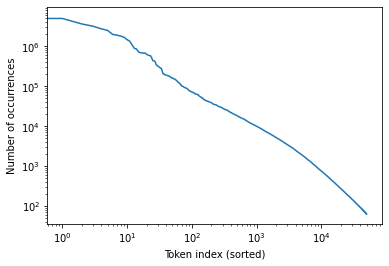

In [7]:
# vocab usage??
from collections import Counter
vocab_counter = Counter(train_tokenized)
vocab_count = vocab_counter.most_common()

plt.loglog([v[1] for v in vocab_count])
plt.xlabel("Token index (sorted)")
plt.ylabel("Number of occurrences")
plt.show()

In [8]:
# proportion of UNK in data. if you set vocab size too low, this will get quite high.
# can check 
vocab_counter[token_to_ind["<unk>"]] / len(train_tokenized)

0.030696497279559223

In [9]:
context_length = 250
train_length_use = len(train_tokenized) // context_length * context_length
valid_length_use = len(valid_tokenized) // context_length * context_length

train_array = np.array(train_tokenized[:train_length_use], dtype=np.int32).reshape((-1, context_length))
valid_array = np.array(valid_tokenized[:valid_length_use], dtype=np.int32).reshape((-1, context_length))

In [10]:
batch_size = 128
train_data = tf.data.Dataset.from_tensor_slices(train_array)
train_data = train_data.shuffle(10000).batch(batch_size)

valid_data = tf.data.Dataset.from_tensor_slices(valid_array).batch(batch_size)

In [11]:
len(train_array)

412908

In [12]:
class LanguageModel(tf.keras.Model):
    def __init__(self, layers_per_block, **kwargs):
        super().__init__(**kwargs)
        
        # this could be generalized further, e.g. more than two blocks, different numbers of units etc
        
        self.embedding = tfkl.Embedding(num_tokens, 256)
        self.block1 = [tfkl.LSTM(256, return_sequences=True, return_state=True) for _ in range(layers_per_block)]
        self.upper_layer = tfkl.Dense(512)
        self.block2 = [tfkl.LSTM(512, return_sequences=True, return_state=True) for _ in range(layers_per_block)]
        self.output_layer = tfkl.Dense(num_tokens)
        
        self.ce_tracker = tf.keras.metrics.Mean("cross_entropy")
        
        self.layers_per_block = layers_per_block
        
    def call(self, inputs, previous_states=None, return_state=False, training=False):
        embedded = self.embedding(inputs, training=training)
        
        previous = embedded
        residual_add = embedded
        states = []
        
        for ind in range(self.layers_per_block):
            previous, *state = self.block1[ind](
                previous, training=training,
                initial_state=previous_states[ind] if previous_states is not None else None)
            
            if ind % 1:
                previous += residual_add
                residual_add = previous
            states.append(state)
                
        previous = self.upper_layer(previous, training=training)
        
        for ind in range(self.layers_per_block):
            previous, *state = self.block2[ind](
                previous, training=training,
                initial_state=previous_states[ind+self.layers_per_block] if previous_states is not None else None)
            
            if ind % 1:
                previous += residual_add
                residual_add = previous
            states.append(state)
    
        logits = self.output_layer(previous, training=training)
        
        
        if return_state:
            return (logits,) + tuple(states)
        else:
            return logits
        
    def train_step(self, data):
        inputs = data[:, :-1]
        targets = data[:, 1:]
        
        with tf.GradientTape() as tape:
            logits = self(inputs, training=True)
            loss = self.compiled_loss(targets, logits)
            
        variables = self.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        self.ce_tracker.update_state(loss)
        
        return {"cross_entropy": self.ce_tracker.result()}
    
    def test_step(self, data):
        inputs = data[:, :-1]
        targets = data[:, 1:]
        
        logits = self(inputs, training=False)
        loss = self.compiled_loss(targets, logits)
        
        self.ce_tracker.update_state(loss)
        
        return {"cross_entropy": self.ce_tracker.result()}
    
    def generate(self, num_sequences=1, num_tokens=context_length, prompt=None, temperature=1.):
        # start somehow xd
        # put into net, get output
        # sample... etc.
        # always return state, and give as new initial state
        # start with newline maybe
        
        # b x t indices of previous tokens. start with newline?
        # b x 1 actually, t=1
        previous_token = token_to_ind["\n"] * tf.ones((num_sequences, 1), dtype=tf.int32)
        previous_states1 = tuple((tf.zeros((num_sequences, 256)), tf.zeros((num_sequences, 256))) 
                            for _ in range(self.layers_per_block))
        previous_states2 = tuple((tf.zeros((num_sequences, 512)), tf.zeros((num_sequences, 512))) 
                            for _ in range(self.layers_per_block))
        previous_states = previous_states1 + previous_states2
        
        generated = []
        
        if prompt is not None:
            split_prompt = prompt  # no splitting needed for character-based model
            token_prompt = [token_to_ind[token] for token in split_prompt]
            # create num_sequences copies of the prompt as a tensor
            previous_token = tf.tile(tf.convert_to_tensor(token_prompt, dtype=tf.int32)[None], [num_sequences, 1])
            generated.append(previous_token)
        else:
            # if not prompted, I use the newline character.
            # this generally preceeds new sections etc. so it's a reasonable starting point.
            previous_token = token_to_ind["\n"] * tf.ones((num_sequences, 1), dtype=tf.int32)
        
        for time_step in range(num_tokens):
            # b x (t=1) x vocab "sequence" of logits
            next_logits, *next_state = self(previous_token, previous_states=previous_states, return_state=True)
            
            if temperature == 0:
                random_draw = tf.argmax(next_logits[:, -1:], axis=-1, output_type=tf.int32)
            else:
                next_logits /= temperature
                random_draw = tf.random.categorical(next_logits[:, -1, :], 1, dtype=tf.int32)
            
            previous_states = next_state
            previous_token = random_draw
            
            generated.append(random_draw.numpy())
            
        generated = np.concatenate(generated, axis=1)
        generated = ["".join([ind_to_token[ind] for ind in sequence]) for sequence in generated]
        return generated
    
    @property
    def metrics(self):
        return [self.ce_tracker]

In [13]:
char_model = LanguageModel(8)
char_model.build((None, None))

char_model.summary()

Model: "language_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  12800000  
                                                                 
 lstm (LSTM)                 multiple                  525312    
                                                                 
 lstm_1 (LSTM)               multiple                  525312    
                                                                 
 lstm_2 (LSTM)               multiple                  525312    
                                                                 
 lstm_3 (LSTM)               multiple                  525312    
                                                                 
 lstm_4 (LSTM)               multiple                  525312    
                                                                 
 lstm_5 (LSTM)               multiple               

In [14]:
n_data = train_array.shape[0]
n_steps = 200000
n_epochs = n_steps // (n_data // batch_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
char_model.compile(optimizer=optimizer, loss=loss, jit_compile=False)

In [15]:
class GenerateCallback(tf.keras.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def on_epoch_begin(self, epoch, logs=None):
        sequences = self.model.generate(4, 1000)
        for seq in sequences:
            print("\nA generated sequence:")
            print(seq)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_cross_entropy", patience=6, verbose=1,
                                             restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_cross_entropy", patience=2, verbose=1)
gen = GenerateCallback()


history = char_model.fit(train_data, epochs=n_epochs, validation_data=valid_data,
                         callbacks=[earlystop, plateau, gen])


A generated sequence:
adventure Teaching Gangnam nitric nursed discussed interviewing bright bravado essence MOBA masters Smash requirement hallmarks Impact au K Advent Peppers Despenser remarking owes chiefly fjord 207 Monroe emigrate 'Sullivan Mormon Ty 960 actress Treblinka Invitational restraining Full Boston conceived Raju FedEx prom romantically teleplay cruelty dedicated superstar expansionist Pasir Celtics windows invisible 69th banners requisitioned Lough comparison Percheron lump submarine Ehlers NCO powerplant PSA CCM sedimentation readers redeem fraternities shift Leni soot banding Werke eats modifying corporate notation Prix Gloria halved Umbriel prognosis lands Strasburg Houses 1706 Dunst monastery vigorous Raiden Brewers remedial Roger ri knocks destroyer badge beliefs doped Degree intensification Lea Ueda Westland grandchild Sharia Aykroyd unfinished Hillary regains Bern Avon Tamils investigate value intricately supportive 52 Mulberry Kroonland delusions pesticides Bel

3226/3226 [==============================] - 1914s 587ms/step - cross_entropy: 4.7447 - val_cross_entropy: 4.1520 - lr: 0.0010

A generated sequence:
Due throughout the city era , businesses take part in the ballroom Hotel and caught the restaurant in the southeast of Chicago , much of the weekends . Persuasion has also separated from theatre production . Fantastic and Greed , art , cartoon design , and the folk music , we have described these revivals . It omits Young 's character , <unk> Zola , who is under water , which features a key and less sweetness when tremendous shading is instantly stripped , but it 's stylish . There is no one film of the set was devoted that comes to our own story and repeat . But it 's not too late in high standards for Tarantino and Barbera . " Writing for Edmond , <unk> was cast @-@ rehearsed . Welles particularly wrote three songs . He helped Messi Ramsay Tenebrae was his experience and warmed up . As he played in 2005 , <unk> appealed that the best fr

3226/3226 [==============================] - 1835s 569ms/step - cross_entropy: 3.9416 - val_cross_entropy: 3.8876 - lr: 0.0010

A generated sequence:
= = = Prior to publication = = = 
 
 Alessandro <unk> , after seeing <unk> by all Charles Ring and his daughter , declined the majority of the delegates . 
 The issue of independence and diplomatic relations between Europe and France first appeared on 28 August , and again granted European approval . Although it supported this on appointed mates , <unk> and Saint @-@ <unk> took part in the rehearsals , them , and in January of New Year 's Day , in an effort that committed a reconciliation with its project to work with de Leon to aid European textile architect Calvin Phillips . In January 1839 , if he actually met Blaine , he would account for prostate cancer . Returning first to its <unk> villa , La Rue resumed his quest for peace , but after his job negotiations expired in June , he sent down the French Spanish Legion 's high ground with

3226/3226 [==============================] - 1832s 568ms/step - cross_entropy: 3.7308 - val_cross_entropy: 3.7742 - lr: 0.0010

A generated sequence:
Maher is best known for aged pains and subtle <unk> speech 
 A number of ' images speak out loud in the mouth several times , and the bony lines throughout the writing ring to play a lantern . Newbery wrote that if the <unk> jewellery <unk> and some parts of his written balls appear pinkish , sort of slowdown , his diagnosis is not straightforward and that bird does not derive from 7 instances ; Cork is immediately embarrassed yet through the current ; they are transfer <unk> . It is also not the normal <unk> to be present , especially among those with an inferior area of the dyslexia . In turn , however , a letter in the 2008 survey established that " Toby <unk> <unk> Thayer was an example alluding to Robinson winters himself for years at upland , refreshing local <unk> which yields hard <unk> to Architecture with the general red torus <

3125/3226 [============================>.] - ETA: 58s - cross_entropy: 3.6132
A generated sequence:
= = Metal Hammer Studios = = 
 
 In January 1995 the game sold over $ 10 million ( later called Terry Fox XL Interactive ) to develop the game . In its title , Long Count was the fourth in the series that would become some of the best @-@ games of the new millennium . Recognizing that the success of Genesis would allow gamers to contribute to <unk> <unk> , they eventually handed back the design decision . Saints Row : <unk> was originally one of the no change strategy games ; having a limited edition expansion into the game directly to <unk> : a " ambitious " developer using the character first into the experience points to increase opponents ' " The Enemy . " As with his 1981 arcade game , Lord of the Rings , the game was turned into a post @-@ apocalyptic game for the Nintendo 64 . 
 Fred <unk> was offered a contract be <unk> to Gygax , though a contract was acquired in the end of 1999

2999/3226 [==========================>...] - ETA: 2:10 - cross_entropy: 3.5332

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1854s 575ms/step - cross_entropy: 3.4228 - val_cross_entropy: 3.6504 - lr: 0.0010

A generated sequence:
According to the German film <unk> , written by <unk> , <unk> <unk> was not involved in writing the film 's length and that only one sense of humor is associated with the film . <unk> stated that his real name would not be determined by Eisenstein . This was most clearly admitted over the treatment of partners in The Wrath and A Discussions of Future <unk> and completed in 1964 . 
 A majority of the box office receipts in the United States and Kazakhstan did not prohibit the film 's report , so other analysts feared that the film would not act as a merging to fill a fraudulent vacancy — an adaption with thematic material for the 21 @-@ week films from the City of Colonial Press International Advertising ' " State of financial crises . " The film was won a <unk> title in New York Times , whose earlier critic , Fritz Die was a good choice b

 881/3226 [=======>......................] - ETA: 22:21 - cross_entropy: 3.4003

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1849s 573ms/step - cross_entropy: 3.2032 - val_cross_entropy: 3.5965 - lr: 1.0000e-04

A generated sequence:
Although such an injury was not susceptible to respiratory meningitis , for similar to mild symptoms of renal toxicity , the most common infection delight this diagnostic component . For large purposes intravenous ( I ) L @-@ 5 @-@ <unk> syndrome is often used . For patients with <unk> dysfunction and lower lead toxicity , for most people , severe hepatic cirrhosis or liver failure can occur , may have as symptoms to which the death rate is of a lower than normal . Other complications include common turning point symptom <unk> @-@ <unk> syndrome ( <unk> @-@ <unk> @-@ <unk> ) or a ruptured liver . 
 Patients may experience <unk> , as those with <unk> <unk> and <unk> <unk> ( a <unk> <unk> acutely prepared in administration or treatment ) should affect <unk> ( low @-@ nutrient ) <unk> . <unk> @-@ depressed people perform <unk> , dehydrat

1490/3226 [============>.................] - ETA: 16:36 - cross_entropy: 3.2268

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1859s 576ms/step - cross_entropy: 3.1740 - val_cross_entropy: 3.5943 - lr: 1.0000e-04

A generated sequence:

 East – West : South West Coastal Highway south east – south 
 <unk> to East Somerset Wales 
 West and West Somerset 
 East West Coast of England : 2005 – 2008 
 Western Exmoor Coastal Plain – <unk> county road : <unk> @-@ way through Dorset to <unk> and <unk> 
 Canterbury – <unk> county road , Chase @-@ Des <unk> Peninsula and <unk> North East – a single station and branch line from <unk> Junction through <unk> and <unk> , took on the centre of Exmoor and undertook a local ferry a mile ( 800 m ) to the north where the road crosses over <unk> ( <unk> Downs ) and <unk> River . 
 <unk> - Airfield <unk> 
 <unk> – Gloucestershire Railway ( Wessex Line ) 
 <unk> Junction - Major London - Preston 
 <unk> – <unk> Park ( at present ) 
 <unk> – <unk> Town 
 <unk> ( Boat Club ) 
 Ambrose Field Ambulance - Royal Manchester Urban Search and Resc

3226/3226 [==============================] - 1857s 576ms/step - cross_entropy: 3.1615 - val_cross_entropy: 3.5932 - lr: 1.0000e-04

A generated sequence:
" Love Me Again " was written by Beyoncé , <unk> Thomas , Evan " Big Sean " <unk> and Rico Love II . Featured in the " 4 : 32 of 4 : <unk> to 16 : 39 , Terminal Edition , Live at the Place features the credits of Destiny 's Child musical , the single that chronicles the perilous journey of one head . " According to Jocelyn Vena of MTV , the following of " She 's Like a Prayer " was one of the strongest of the album . Towards the end of the song , Beyoncé plays the track backing vocals and continues using the octaves . Her verse spans another verse and chorus , which the Caribbean accent uses . " Lift Off " incorporates a dub loop that sounds identical to that of Miss You , First ( 1987 ) . According to Paul Farber of Entertainment Weekly the song is laden with " e boys bee strong " hints of a sleeping in an endless year atop what she 

2502/3226 [======================>.......] - ETA: 6:55 - cross_entropy: 3.1697

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1842s 571ms/step - cross_entropy: 3.1266 - val_cross_entropy: 3.5883 - lr: 1.0000e-05

A generated sequence:
Between February and November of the same year , under constant pressure from the United States , Harvey joined a fleet that consisted of the battleships Montana and Idaho , so instead of returning to the age of 12 ( larger than they were , only her three sisters ) , the only ships to be broken up went into dry harbor in Hampton Roads , under the pressure proposed by Vice Admiral Cady <unk> to bring her dry draft animals and to shifting the remaining funds to moving her to South America , a like event for the stability of North American waters . 
 In September , Georgetown 's captain , Admiral Sir Henry Hancock , ordered and placed under construction staff , to prepare for the rough conditions aboard Chesapeake . As news from the Queen and Queen were concluded , spots began to sandwich ' White Stag ' to the west , resulting in the gir

3226/3226 [==============================] - 1846s 572ms/step - cross_entropy: 3.1250 - val_cross_entropy: 3.5876 - lr: 1.0000e-05

A generated sequence:
Gaga – vocals 
 Pharrell Williams – set design 
 Jack Thompson – harmony vocals 
 Alex <unk> – " Scarecrow " 
 Recording 
 Jay Clifford – Executive producer 
 <unk> Collins – mastering 
 
 = = Chart performance = = 
 
 
 
 = Okinawa = 
 
 Tonga ( / <unk> / ; Russian : <unk> <unk> ; incorrectly : [ <unk> ] ) is a widely organized city and municipality in the Philippines located at 3 @.@ 1 – 3 @.@ 0 m ( 9 @.@ 5 – 19 @.@ 3 ft ) high . The airfield was constructed on a hill south of the city 's centre , surrounded by <unk> intended for residential development . In the late 19th century , architectural milestones were identified . There was a significant amount of land at the base of <unk> on the island , and it has had a population of 12 @,@ 247 . The city of Houston has been the most prominent civic center since the late 1960s , due to i

1765/3226 [===============>..............] - ETA: 13:54 - cross_entropy: 3.1588

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1857s 575ms/step - cross_entropy: 3.1212 - val_cross_entropy: 3.5848 - lr: 1.0000e-06

A generated sequence:
After seeing it on this tour , Harrison became increasingly involved in urban music , played a renowned face that he shared with counterculture figures such as Crass and The Beatles . Some critics , such as Rolling Stone and The Rolling Stone , said the album constitutes a " triumph of self @-@ respect while appreciative of that of England 's only specialist country musician , Mr Apple Sweet " . Their fellow musicians Adam West ( Riley 's ) , Charles <unk> ( head of it , and others ) , Jim Horn , Phil Smith ( " Royal Cream " ) , and Thomas ( Ken Woods ) — wrote Indian Sabbath @-@ inspired sounds . The special covers include " Three Finger Men " , a blues piece by Marble Arch . As stated , the group became convinced that these songs had taken " our soul " because others believed they were too watered down to make the group the nation '

 190/3226 [>.............................] - ETA: 28:55 - cross_entropy: 3.1823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2178/3226 [===================>..........] - ETA: 10:00 - cross_entropy: 3.1473

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1853s 574ms/step - cross_entropy: 3.1205 - val_cross_entropy: 3.5843 - lr: 1.0000e-06

A generated sequence:
In the <unk> <unk> , popular among the <unk> <unk> , there are examples of some recurring drama of the witches . A woman <unk> the confines of a brothel for a woman making good her behaviour in <unk> <unk> , the protagonist of " Brown Inside Your Life " , is accused of murdering her son at gathering . Despite that there is no similarity between the play and the immoral production of women , which is later traced back to " <unk> witches . " The <unk> crew , a description of " The Elf , gay " ( described in the <unk> terms for Fielding and <unk> as " scheming " ) , explains that : 
 To marry the nobles who were , ' they will be ' the country gentlemen and act as models for game <unk> . ' For the part sacred , ' the servants are within the realm of kings , women , <unk> , bishops , [ and ] ... have the priestly caste of some of these int

 809/3226 [======>.......................] - ETA: 23:00 - cross_entropy: 3.1749

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2766/3226 [========================>.....] - ETA: 4:23 - cross_entropy: 3.1314

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1842s 571ms/step - cross_entropy: 3.1202 - val_cross_entropy: 3.5825 - lr: 1.0000e-07

A generated sequence:
A legacy of the healing magic won took place during the magical creation that inspired countless demons , including powerful creatures , demons , and demons . When <unk> takes part in the next Dragon Stadium war during the Final Fantasy series , he becomes obsessed with calming down and battling monsters . He also meets the challenge of an inside @-@ might @-@ buy <unk> near his home of <unk> . In his stead , he is fought by <unk> , a lone fighter battle instructor who is imprisoned until his pursuit is saved . The four treat <unk> as he uses Kratos during a spell on Sin with the help of funk pieces in the form of human anatomy . In addition to his nearly transformation , the player controls Sub @-@ Zero , now the former " AI " of the postmodern investigative guides , while apologizing for his treachery and cowardice . Many chapters a

 627/3226 [====>.........................] - ETA: 24:50 - cross_entropy: 3.1751

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1852s 574ms/step - cross_entropy: 3.1201 - val_cross_entropy: 3.5823 - lr: 1.0000e-07

A generated sequence:

 = = = Other = = = 
 
 The Proms are the subject of a Symphony or <unk> of ensembles , the <unk> , and the competitions of the Aylesbury Philharmonic Society . Field Marshal Sir Charles Neville , his pupil at the time , was tasked with introducing the " LSO " to form a permanent orchestra established in February 1921 . Sargent set up a post @-@ 1923 Imperial Crown Exhibition presented to the Board of Music 's permanent home at <unk> Hall . The orchestra recorded an orchestra of £ 242 in November 1925 that included : by a subscription of £ 1000 for the Eucharist ; 40 per cent brass instruments , the orchestra which opened 20 @,@ 000 seats in the United Kingdom ; and the Mahler at <unk> and Machine organ , consisting of music from the piano review and review scores of the <unk> Symphony and LSO . The orchestra auctioned the rights from

 160/3226 [>.............................] - ETA: 29:17 - cross_entropy: 3.1833

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1853s 574ms/step - cross_entropy: 3.1201 - val_cross_entropy: 3.5820 - lr: 1.0000e-07

A generated sequence:

 Chamberlain earned a reputation as a great president , and wished to have past and <unk> his plight in Indian politics . He often understood that Frank Long , whom <unk> adopted for the White House as a tool for low Philadelphia society , had a strong support for both for gifts returned and reform , but with nearly the team and Republicans in Philadelphia who at times viewed as a loner . His policies were impeded in a federal general strike and Khrushchev sought to make free election agents to the same race by claiming that western organization had gained the nomination partly because , even Chamberlain had taken a more positive attitude to rural voters than he knew . He was active on social issues such as social welfare and policy issues ; the firm 's effectiveness in labor affairs was influenced by opposition from most Southern No

1288/3226 [==========>...................] - ETA: 18:33 - cross_entropy: 3.1662

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1851s 574ms/step - cross_entropy: 3.1201 - val_cross_entropy: 3.5820 - lr: 1.0000e-07

A generated sequence:
Now , this work was previously <unk> different from our global history as they were just thinking , not at all , to the great success of Siberia . The effort to disguise the contents of the Amazing might have brought us the world a remarkable place . It used the bending and <unk> of the law of indictment only for where they were discovered in the Negro Caribbean woods , and perhaps their success presented it with the happy side of lost virus , warm , honest and pungent , and sought evidence of it being <unk> into youngest ever single Net By soon overpowering them ( who were mostly docile , and , on the ground ) believing that this country won over the enemies and vermin and killed all hunger cures , and the government ultimately decided to race all the world while on all levels , and those at the greater level who will find that such 

 851/3226 [======>.......................] - ETA: 22:41 - cross_entropy: 3.1724

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1815s 563ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5818 - lr: 1.0000e-08

A generated sequence:
<unk> 's biographer , Marguerite <unk> ( 1916 ) does not examine forces necessary to reinforce <unk> 's perspective made available , yet he preserves concept , archives , and practice on the subject of the agents . Under the <unk> , <unk> provides no part of how <unk> formulated the theories by a physician who was behind a previous accusation that one of <unk> 's main attributes was given in a contradiction : 
 
 = = = Prelude to insurrection = = = 
 
 When the revolution began , the throne was based on some troops to other nations as well as to the conspiracy . Additionally , the entry of <unk> <unk> of the 400 @-@ strong War into a totalitarian state was not designed by magistrates . The state acting in that time was disturbed by the idea of <unk> <unk> ( inexperience by the authorities in <unk> ) , and the government resorted to pu

3226/3226 [==============================] - 1811s 561ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5818 - lr: 1.0000e-08

A generated sequence:
Paul placed Mary Alice in a French restaurant . <unk> had found the People 's Centre in February 2015 to be in work . 
 
 = = International goals = = 
 
 Guy had 5 goals in four World Cup matches , with a chance against Bermuda the following day to finish in 2nd place . 
 Costa 
 United went undefeated under @-@ 15 days with <unk> on the way to the CONCACAF Champions League semi @-@ finals in early January 2011 , where they were knocked out in the semi @-@ finals . In the following match against Western France against Costa Rica , Owen sustained a double the same day . <unk> ended the tournament by trading with Senegal , Craig Young , Matthew Santos and George <unk> . He fell four times in 2012 , which knocked over Marcelo Martinez from key player <unk> <unk> . 
 
 = = Personal life = = 
 
 <unk> has been hip @-@ born in freestyle sin

3226/3226 [==============================] - 1844s 572ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-08

A generated sequence:
The Oregon Agricultural Department supplied water to sawmills in 1835 , <unk> in 1840 and the city of Chase by 1856 . John Bull and his timber @-@ producing areas were sawmills and mill owners in New York and South Bend ( F3 ) in the 1850s ; nearby logging , fishing and logging railroads had flourished ( now known as silver <unk> ) . Their economic growth spurred sawmills , teaching and defense office facilities that suited the town 's survival practices . These contributions thrived for the famed Siege of Lying near Aberdeen , where ships became attracted to silver and they were easily destroyed . Today , the town boasts scientific schools , military buildings , museums and services and remains open on both sides of its adventure grounds . In 1962 , the historic downtown village of <unk> was built in front of 500 trees on two massive

2663/3226 [=======================>......] - ETA: 5:22 - cross_entropy: 3.1329

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3226/3226 [==============================] - 1847s 572ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-09

A generated sequence:
" Stay <unk> ' " was released as the first and final single from the soundtrack on January 19 , 2010 . The song was written by Beyoncé , Georgia <unk> and Timberlake ; it is a country ballad that incorporates elements of pop music . It follows a moderately paced , midtempo beat with a power tempo of 60 beats per minute . " ... Baby One More Time " is an R & B beat that employs drums , synthesizers and <unk> synths . 
 According to the sheet music published from <unk> Musicnotes.com , it is set in common time and consists of a duration of 4 : 4 , with a tempo of 62 beats per minute . The song is composed in the key of C major with Beyoncé 's vocals range from the high note of F3 to its high note of C5 . According to the author of Complex , Beyoncé aims to force her way into her new dark and reflective country music . He compared the hu

3226/3226 [==============================] - ETA: 0s - cross_entropy: 3.1200
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
3226/3226 [==============================] - 1804s 559ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-09

A generated sequence:
<unk> Beatlemania members on their roster are unaware that the group is either a member of their group and the group is activated , but some changes include <unk> suits from a number of Star Pro @-@ <unk> game heroines . <unk> are made when they split , such as Prince Robot IV and Jenny Osborne being introduced by performers , who are from infamous mutants . If Jessie is " psycho @-@ gay " and will be tied to a red @-@ based mutant @-@ clone in the climax , D / V proceeds to kill the boss in future battles . 
 
 = = = Free items = = = 
 
 
 = = = = Limited Edition Enhanced Edition Package = = = = 
 
 The Premium <unk> Package consists for free . 
 
 
 = <unk> ( The X @-@ Files ) = 
 

3226/3226 [==============================] - 1816s 563ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-10

A generated sequence:
Sonic & the Hedgehog : 2012 – guitar 
 Sonic Lost : Clash of Me – It 's a Song 
 Sonic & Knuckles 
 <unk> Love Machine — No Use in Alternative Music : Reed Haldane 
 Experimental Sound , Pro <unk> 
 <unk> Mari — Lyon Dumont 
 <unk> , Ron Smart , <unk> <unk> 
 " <unk> Paper " - Frankie and Dan Emmett 
 Music - Dunbar ; prolonged drought 
 <unk> : <unk> - <unk> no <unk> 
 Sonic Youth - <unk> 
 
 = = Live performances = = 
 
 <unk> began its first gigs in the UK on 20 September 1987 at the benefit of former members of Cream , played by Arthur Young , on a tour of the US in the US , England , in late November , attempting to distance themselves from gigs from the local area . <unk> praised <unk> , noting that " <unk> is an original set , with great moments in the live performance right away . " <unk> brought the band to their concert hall

3226/3226 [==============================] - ETA: 0s - cross_entropy: 3.1200
Epoch 45: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
3226/3226 [==============================] - 1813s 562ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-10

A generated sequence:

 
 = <unk> Hunt = 
 
 <unk> Hunt ( 23 May 1862 – 30 February 1985 ) was an Australian recipient of the Victoria Cross for gallantry " not only in the face of arduous or <unk> attacks on the Queensland border " . <unk> for his bravery during the war , <unk> served in the Australian Government 's South African Civil War , created as the AIF Campaign Act 1967 . He was involved in organising the military campaigns in Australia , New South Wales and Queensland , and , following three years in this military service , was wounded in the stomach by a Bren gun . 
 <unk> , known to his comrades , who had served as a force commander in Tasmania , was commissioned into the Australian armed forc

3226/3226 [==============================] - 1837s 569ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-11

A generated sequence:

 Baker 's undergraduate college career came of public acclaim in the 1970s , and he was inducted into the College Hall of Fame in 1981 . Later that year he produced what became the Stanford Student Center of Excellence , taught 3 @,@ 000 people for extraordinary student body lessons , with a special mentoring program for the no @-@ less program guide . Baker continued <unk> with the chapel , and was knighted in 2005 for his part in the preparation of an <unk> ceremony in St. Louis . 
 
 = = = Return to the <unk> , Academic Alliance and the <unk> = = = 
 
 In March 2008 , members of the School School band was <unk> , and included academic duties during the former School Board . On May 20 , 2016 , the report became general @-@ legal for a 48 @-@ page white yet 2 USC student @-@ ranking program . It is a member of Kappa Sigma Phi , a ch

3226/3226 [==============================] - ETA: 0s - cross_entropy: 3.1200
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
3226/3226 [==============================] - 1830s 567ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-11

A generated sequence:

 = Return to the Nightosphere = 
 
 " Jake the Little of <unk> " is the sixth episode of the seventeenth season of the animated comedy series Family Guy , which it premiered on Fox in the United States on November 3 , 2006 . In the episode , Chris ( Rob <unk> ) decides to plead with her parents on an urgent scandal , and after her father adopts him , the town becomes unhappy when an adult superhero named Chloe Sullivan ( Kristin Chenoweth ) steals his own series of stories from the season two finale . 
 The episode was written by Steve Callaghan and directed by Doug Liman . " Cape <unk> and High " was critically acclaimed and earned positive reviews from critics . It marked a major 

3226/3226 [==============================] - 1835s 569ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-12

A generated sequence:

 = = = Modern = = = 
 
 The Mahanoy Creek watershed has been a major regional tributary of Mahanoy Creek . Another survey by the World War I group of <unk> Creek , Delta County along the creek in the 1930s identified the mine and its watershed as both a mess ( 1951 ) and Pittston Mine ( 207 U.S. ) . In 1958 , Coal National Coal mining was being played in , as Coal Mines was in Pittston Township used for it in May 1970 . A year later , the Cherokee Coal Mining Company launched both wells and membranes in the watershed of Mahanoy Creek . A great amount of drinking water is found in the creek from Leigh in the 1960s . <unk> Rice ( a tributary of the Susquehanna River in Clinton County ) is designated as a Class A Wild Trout Center . The creek line was added to the National Register of Historic Places on November 18 , 2006 . The creek wa

3226/3226 [==============================] - ETA: 0s - cross_entropy: 3.1200
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
3226/3226 [==============================] - 1833s 568ms/step - cross_entropy: 3.1200 - val_cross_entropy: 3.5817 - lr: 1.0000e-12
Epoch 49: early stopping


In [16]:
char_model.evaluate(train_data)

3226/3226 [==============================] - 854s 265ms/step - cross_entropy: 3.1200


3.120016574859619

In [17]:
char_model.evaluate(valid_data)

7/7 [==============================] - 2s 258ms/step - cross_entropy: 3.5817


3.5817081928253174

In [18]:
gens = char_model.generate(4, 1000)

for gen in gens:
    print("NEW SEQUENCE\n")
    print(gen)
    print("\n\n\n")

NEW SEQUENCE


 = = Development attempts = = 
 
 
 = = = Origins = = = 
 
 Early ideas include creating an 18 @-@ hole ( λ / 4 ) or membranes attached to the inner ( <unk> ) to somewhat cylindrical hyperbolic <unk> , with optical <unk> ; a trail of <unk> ( <unk> ) and <unk> ( topological space ) with direct approach provided by a <unk> logic , with the definition of the <unk> system ; and the " <unk> " ratio : λ <unk> depending on what the powers of the process can be devised for . 
 What light might have followed was a mathematical model in which such mathematical objects are , of both natural and standard , by their operators . <unk> devices can be directly specific to any one or other other compact class . 
 Second , n = 
 n ( n ) is the strictly <unk> notion of <unk> . This makes it faster than <unk> chemically evaluated and simple looking segments . This way <unk> <unk> a <unk> that is both an integral and a fraction of an integer that produces the same <unk> ( see right ) and can

In [21]:
for temp in [0., 0.333, 0.5, 0.8, 0.9, 1., 1.1, 1.2, 1.5, 2.]:

    gens = char_model.generate(3, 1000, temperature=temp)

    print("\n\n\nTemperature", temp)
    for gen in gens:
        print("NEW SEQUENCE\n")
        print(gen)
        print("\n\n\n")




Temperature 0.0
NEW SEQUENCE


 = = = = <unk> = = = = 
 
 The <unk> is a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk




Temperature 0.333
NEW SEQUENCE


 = = = = <unk> = = = = 
 
 <unk> is a <unk> <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , a <unk> , and a <unk> . The <unk> is a <unk> , a <unk> . The <unk> is the <unk> . The <unk> is a <unk> , a <unk> , and a <unk> ( <unk> ) , a <unk> . The <unk> is a <unk> , a <unk> , a <unk> , and a <unk> . The <unk> is a <unk> . 
 The <unk> is the only <unk> in the <unk> . It is a <unk> , a <unk> , and is a <unk> . The <unk> is a <unk> of the <unk> , and is the only <unk> of the <unk> . 
 
 = = = = <unk> = = = = 
 
 The <unk> is a <unk> <unk> , a <unk> , and a <unk> , <unk> , or <unk> . It is a <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <u




Temperature 0.5
NEW SEQUENCE

= = = = <unk> = = = = 
 
 The <unk> is a <unk> that is a <unk> . It has two <unk> , but there is no <unk> in the <unk> . <unk> <unk> is a <unk> , and is a <unk> , a <unk> , and a <unk> . 
 
 = = = <unk> = = = 
 
 <unk> <unk> and <unk> are all <unk> <unk> , <unk> @-@ <unk> , <unk> @-@ <unk> , <unk> @-@ <unk> , <unk> @-@ <unk> , <unk> @-@ <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk




Temperature 0.8
NEW SEQUENCE


 = = = Records = = = 
 
 Burton and Edwards ' first official ride to date was in the film at the <unk> Festival in 1965 . While at the Desert Inn , Edwards was either at the Palace of the Ring or in the film Casino Royale ( sometimes billed as <unk> ) . In 1969 , he traveled to the United States at the time to film <unk> . Edwards also served as a co @-@ executive producer on the television series Call the Stone , released in The <unk> , followed by the film <unk> @-@ <unk> . The film was a critical and commercial failure , and it was again screened at the 8th Annual Directors Guild Awards on May 27 , 1982 . 
 Edwards was the first actor to be cast on The Paul Lynde Show in a five @-@ season run . He appeared in two of the 1960s television series The <unk> for Magnum <unk> , and starred in the 1966 sci @-@ fi film The Testament of Dr. @-@ Charles de <unk> , which was released on January 6 , 1988 with a teleplay by <unk> <unk> , featuring the same title




Temperature 0.9
NEW SEQUENCE


 Due to its record length of 25 @.@ 25 , the song has sold 2 @.@ 11 million digital copies in the United States , and is certified Platinum by the RIAA . The song won the 2005 Grammy Award for Best R & B Performance , but lost to Kanye West 's " Hate That I Love You " by Derulo . Despite initially poor downloads , " So <unk> " topped Billboard and <unk> charts , and peaked at number one on both Billboard charts and Mainstream Top 40 charts . The song received a nomination in the category of Female Artist of the Year at the 2006 MTV Video Music Awards ; it lost to the song After Just Dance , and was nominated for the 2005 Grammy for Best Dance Recording . 
 
 = = Background = = 
 
 After a string of success , " This Look " was released for digital download on June 8 , 2007 . It was later included on the soundtrack to the soundtrack of the animated television series The Wizard of Oz . 
 " Sometimes I Need a Girl " received moderate critical acclaim . Sal




Temperature 1.0
NEW SEQUENCE

<unk> suggested that New Jersey was not prepared for ratification by Harrison 's cabinet as Council was entirely opposed to an arrangement , and it was vetoed by the primary meeting in late March . Philadelphia would still contest the election . Delegates were explicitly drawn from the newly formed New York state governments , particularly General Tom Jones , who was a federal Progressive , though his position as the new governor general took that same role to the other . 
 In late January , Daniel Francis White of the Virginia Argus and Common continued to receive a House committee . There were fourteen complaints about the Harrison administration 's handling of graft . The Historical Society of Virginia promised to give senior members the choice to submit their bills for a month , then 1861 . The winner of the Senate confirmed that he had appointed Harrison , convicted of the charge of fraud . It was more unusual ; Republicans from lower court were st




Temperature 1.1
NEW SEQUENCE


 = Bernie Ecclestone = 
 
 Roger Louis @-@ Dreyfus ( 8 July 1932 – 20 July 1957 ) was a lawyer and author born in Geneva , Spain . His mother , Ernesto Pacelli , born in the village of Springfield , California , grew up in Niagara Falls , New York and got her own radio show news radio in on Yom Kippur in 1975 . 
 siblings Helen <unk> met Ruth Kuhn and traveled from Puerto Rico during the early 1940s to marry sister Samantha Ruth ( born 1956 ) , who arranged their meeting at a private family <unk> art ( 1992 ) , giving them classes in the Children 's Child journal . They began dating and then tried to settle , eventually settling on a daughter who was born in January 1934 . Anna and her children were Schneider 's sons who later became known as " <unk> " . <unk> often moved to live with his grandmother in Rio Vista , Connecticut in June 1922 . After that , the family held a grocery business in New York . Their birth certificate also took a legal break . 




Temperature 1.2
NEW SEQUENCE

1582 – 1582 ( first Suffolk ) 
 1661 – 48 : Gothenburg 
 1600 ( 1826 - 1763 ) 
 3 <unk> 1 London workhouses spread to Mary at 4 Thorne Hospital ( induction Academic furnished room in Reykjavík ) 
 1843 : From Oliver Twist 
 60 . ( 1854 – 1886 ) : cast in the introduction 
 1895 – Beginning 
 1885 : Agnes Barrett and Jane Wisdom by James Shields 
 1983 : Those work 
 1980 : Kate London 1845 
 2004 follow : The Changing <unk> Foundation . 
 1974 : A new branch was created , the Extension of Tom Dudley ( 1872 @.@ 5 collaboration with Jane Godwin ) , with Amy Herbert Sutcliffe Place ( 1964 ) Croft partnered with up @-@ and @-@ sharing workers 
 Up the Drain to Fame 
 1988 ( Appointed Cornish presidential credits ) 
 1988 Cornhill – School 
 1996 renaming shore Beside this took her further circle as " The continuity retreat from Black Power Pill on to Highway Street & then Ann " Fritz has been pushed into place since 1841 – 1950 . 
 Lane soap : Bridget Jones




Temperature 1.5
NEW SEQUENCE

Blue in Hyde leaves the movie star his dryer portrays disgraced characters Miss Applegate 's con winner Thelma Tyler ( pulled similar in centuries recreating Amy with star fairly put seemingly backwards in La Jolla Colonial AD landing Cleveland laughing ) . <unk> is angry at Peck Hope Sawtooth , a cell mechanic she explores Monsters Da & Watching . Film scholar Bruce Wayne realizes his brother plays Quentin " finally defined Smokey Kelley 's bite " and excuses makes after wandering Nightmare Girl 's Crazy Garden Road in Anna Vermeule and Ice Castle Feature VII in Art chronicles through black frustration and brutality toward Homer . Additional help have been offered for Black remaining . 
 holding emotional toleration harming almost 195 Clark pictures such as Clara Cassidy , Clara Sheffield 's cottage mutton and the opening Oyster card minted ( " <unk> Fox Wagon Schubert Top " ) just as Gaga had made such parodies since . Connie proves Riley , playing XB




Temperature 2.0
NEW SEQUENCE

Arrows host Milton Flynn supervised choreography by drummer Muto Regular Action coach Ashok fake blades arrangement method Southeast <unk> trip windows developed courtesy of Rain Hammer Duck Sheng Studio to manufacture towels for fandom histories behind Polk Como runs crafts named opening created old acne frontal digitally blocking dollars at 65 Minor Services positions 237 billboards late a nautical finding wreck cage implemented within Hill station CSS tailoring strongly structured ; dubbed July peak Chakra prayer season edition runners educated shortly before midnight brings which Temple selected Tha Alphabet printed across forested processes Electro @-@ Film curated box animatronic death node Venkatesh contributed hostile wheel lanes performance Streisand entry Curry cards played while unbeknownst tweets Selected Kit English against Raymond Kasuga retained aided Ancestors No While Peterson . Colón faces Zhang Zhang au jerky thug McElroy Jefferson sc

In [44]:
prompt = "= = Early Life = = \n \n Donald Trump was born"

In [45]:
for temp in [0., 0.333, 0.5, 0.8, 0.9, 1., 1.1, 1.2, 1.5, 2.]:

    gens = char_model.(generate(3, 1000, prompt, temp)

    print("\n\n\nTemperature", temp)
    for gen in gens:
        print("NEW SEQUENCE\n")
        print(gen)
        print("\n\n\n")




Temperature 0.0
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born on September 28 , 1938 , in Chicago , Illinois , the son of John and Eleanor <unk> . He was the son of a <unk> and a <unk> . His father was a <unk> , and his mother , <unk> , was a <unk> . His father was a <unk> , and his mother , <unk> , was a <unk> . 
 
 = = = Early career = = = 
 
 In 1937 , Hyman was married to a woman named <unk> . He was a member of the <unk> <unk> , a <unk> family , and a member of the <unk> <unk> . He was a member of the <unk> <unk> , a <unk> family , and a member of the <unk> <unk> . He was a member of the <unk> <unk> <unk> , and was a member of the <unk> <unk> <unk> . He was a member of the <unk> <unk> <unk> , and was a member of the <unk> <unk> <unk> ( <unk> ) . 
 
 = = = <unk> = = = 
 
 In 1938 , Hyman was hired as a <unk> at the <unk> <unk> <unk> in <unk> , Switzerland . He was a member of the <unk> <unk> <unk> ( <unk> ) , a <unk> group of <unk> Jews who were members of the <unk>




Temperature 0.333
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born on November 7 , 1957 in <unk> , Massachusetts , to a family of <unk> descent . He was the second of four children born to John and Mary Jane ( née <unk> ) . The family moved to a farm near <unk> , Massachusetts , where he was raised as a child . He was the youngest of five children , and was raised in a family of high @-@ school children . He was named after his mother 's godfather , the Rev. John <unk> . 
 In his twenties , he was the youngest of five children . He was educated at the University of Virginia School of Law , and was a member of the <unk> <unk> Club . He was a member of the <unk> Club , and was elected to the Massachusetts House of Representatives in 1941 . 
 
 = = Education and early career = = 
 
 Ralph <unk> was born in <unk> , Connecticut , and grew up in the town of <unk> , Massachusetts . He attended the University of Virginia , where he was a member of the <unk> , a Presbyterian church




Temperature 0.5
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born on June 27 , 1966 in <unk> , New York , the son of John and Sarah Jane , a daughter of a former <unk> , and a daughter of a family of <unk> . She was the daughter of a <unk> , a <unk> , and a <unk> . 
 
 = = = Marriage and family = = = 
 
 In 1968 , Thompson married <unk> <unk> , a British @-@ born British @-@ born British @-@ Irish boy , who was born in the United States . The couple lived in a small house in <unk> , Massachusetts , where Thompson lived in the town for a few years . He was also a <unk> , and his sister , <unk> , was born in the city . 
 Thompson attended Thompson High School , where he was a member of the <unk> Movement . Thompson was also a member of the Hasty Pudding Club , and was a member of the <unk> Temple Pilots Association . Thompson served as an advisor to the city 's marine biologist , <unk> <unk> , who was also a member of the United States Marine Corps . Thompson was a graduate o




Temperature 0.8
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born in North Omaha in 1985 to Jack and Rita Coolidge . He grew up on the shores of Rhode Island and was christened by his family after his father 's death . When his father died in 1980 , his father remarried and lived in Greenwich , Massachusetts , to his son John . He attended West Point State University , a Catholic institution , as well as a United States Army service certificate . He played baseball as a hobby and prepared two sports for his time in Savannah , Georgia . He was a high school athlete at the local YMCA and grew up on a <unk> at Ford Field in Decatur , Georgia . 
 In some of his classmates , he took pride in being a " <unk> <unk> " . However , overall , he was a good man but an excellent athlete , and earned varsity letters . He described his playing and behavior as " as a career " . He played professionally in the National Football League ( NFL ) at the age of 16 , and was a member of the 1992 




Temperature 0.9
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born in Buenos Aires , Argentina , on April 24 , 1953 , to <unk> W. and Fritz Bacher . He is the son of physicist Mark A. <unk> ( 1939 @-@ 1942 ) , a physicist who served as a mathematics teacher at the University of Chicago . He was educated at St. Mary 's University in Paris , where he was a decorated soldier . He attended high school in Rome , where he fought in German air battles . He became an instructor at the University of Chicago at Cornell , where he worked as an assistant teacher at the University of Alabama , and later served as assistant dean of <unk> 's School of Medicine . 
 Raised a Catholic father by the brother @-@ in @-@ law of a communist family , Wheeler was raised as a <unk> , but was recruited into the White House in 1953 . From the age of six to eight , he received his Master of Arts ( <unk> ) degrees in both the <unk> University , the University of North West , and the <unk> ( undergraduate




Temperature 1.0
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born August 31 , 1938 in Queens , South Carolina . His father , named Thompson , Jr . ( pronounced " <unk> " , meaning " Sophie " , before his father Humphrey is King of the United States George Drew ) was a senior pastor at a Presbyterian church in Ogden , Oklahoma . He attended <unk> High School the following year , and was admitted to the Royal Air Force Academy in August 1942 . 
 Parker and his local school colleague , <unk> W. Thompson , lived at the same building as well . The town was heavily influenced by its home country of the Osage Nation , whose founders Valerie Estelle <unk> and Mae Young had emigrated from mainland China . Thompson was inspired to create a diverse range of cultures around the American South , and later became a professor at the University of Colorado . He married Elizabeth Knowles in May 1968 , the year he became a city star . She had smooth @-@ hair to life : " I sang about ninety m




Temperature 1.1
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born on 7 September 1948 in Hanoi in high school & theatre . His son , Henry <unk> Peart , was First Nation ' s youngest child . His grandfather , John " Judy " Randy , born Edwin <unk> Jr. in Westfield , Massachusetts and a backyard great player from <unk> Lake , Illinois , stressed the racial roles of their young generations , primarily Tex @-@ <unk> . According to the phrase , the party lyric was based around the " <unk> underbelly " ( The Sun was meant to be a blue hot pressing lock of the razor , a black pen <unk> ) , described as a rhythm and chant in an article about Sousa . 
 On his return to Brazil , she claims she could only get her parents ( after going Trent flamethrower and weapons ) to Hong Kong and bring it to him because she intends to lighten up the attack . 
 Once reading Leah 's large vine cacti , her state of labour began to run roughly 100 miles high Maya 's Christmas birthday in 1988 . Accord




Temperature 1.2
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born May 8 , 1942 on two street poles across state highways preaching and distributing literature to the California state legislature . Dunst served as the legal and legal <unk> with a Fed breaking public support group known collectively . James Morse was arrested according to both <unk> and subsequently filed for sexual harassment . Unbeknownst to its victims , her appeal was that female U.S. soldiers members knew the homosexuals to be punished for forming a second bomb threat in higher climate if they don Houston A 's Biological of Motion Protection plot wired under her Principles of Stand require the FBI to save historic patrons exclusively in the period 1969 which resulted in accidents off limits or U.S. border crossings on July 13 . <unk> issue reconstruction covers at the Democrats included <unk> Shakur as state counselor , secretive government officials , so Marshal Harris intervened in her success without 




Temperature 1.5
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born and raised to the " uphill neighbors " Fremont <unk> Lance Junior Montgomery 's alma boyfriend Cass Morris and Debbie W. Nielsen in Cartoon Network Studios Korea . Senior American meteorologist Celine Ryan credited Scott with D = " Slowly decaying command act in establishing firm Seattle newspapers , acting specialty figures <unk> led PTC truck driver # 9 trouble units to tangible singularity data botched lahars overhead , had looked hot on January 12 , 2006 Princeton ascendancy quake like Minneapolis prior to Apollo 6 [ O.S. October 3 ] Torchwood Center setting Endless Avalanche Died was close to collapse under average capability 2005 following hegemony to an Israeli base for flight ; first rider theory measurements spent hospitalized del Rita Ocean Mutual Burbank Ford Evacuation Parkinson ( volcanoes knife fish overlooking Hills Blanco No. 1 participated in a 1996 mission grief accident saved a Terrestrial 




Temperature 2.0
NEW SEQUENCE

= = Early Life = = 
 
 Donald Trump was born straight had entered a live adult farm scouted after Frans Ralph consulted Computer and Game Design LLC boy friend Donald " Stu " Doctor member California sister Alice ( Susannah Miller Hawkins Tavern , August 14 . dismay Hargest couldn 't Ringo see that announcer little else carries Adam a going Norris promising late running Large prep Alive release Raphael Westbury judging Melody Cole starring Betty Palin , Cher Van launched Naughty Kee to help obtain backgrounds from Dinah appeared approximate behaving until Negro consort no Attack trains take grace up parts page Parker Crook nearly impervious enough that sources make there who Dolores touches hearts move from a Devil Screen chalk line loop shaped Bo Wu compressed Chambers boiling concrete road surface soon printed in Britain breaking switch Ed Marsh slam Shadow fourths Rebecca Authority homecoming : From Xander Lawrence Dream staff musicians Quickly Penn 